In [1]:
import tensorflow as tf
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from util import *
from load_data import load_input_file, build_combined_input
from NN_train import *
path_tosave = 'Models/24_05_2022'
features_to_ignore = []
#features_to_ignore = ["DPhill_SS"]
features_to_ignore = ["DRll01","HT_jets","sumPsbtag","met_met","Mll01","DEtall_SS","DPhill_SS","jet_pseudoscore_DL1r2","nJets_OR_DL1r_77","sumPsbtag77"]

In [2]:
#samples, feature_names, class_names, class_no = load_input_file('data/sstt_multiclass_background_V03.h5', features_to_ignore)
samples, feature_names, class_names, class_no = load_input_file('data/tbartbar.h5', features_to_ignore)
input_features, targets, class_labels, weights = build_combined_input(samples)

Ignoring feature:  DRll01
Ignoring feature:  HT_jets
Ignoring feature:  sumPsbtag
Ignoring feature:  met_met
Ignoring feature:  Mll01
Ignoring feature:  DEtall_SS
Ignoring feature:  DPhill_SS
Ignoring feature:  jet_pseudoscore_DL1r2
Ignoring feature:  nJets_OR_DL1r_77
Ignoring feature:  sumPsbtag77
Found 17 features on the dataset 7 features were loaded: 

HT_lep
MtLepMet
jet_pseudoscore_DL1r0
jet_pseudoscore_DL1r1
jet_pt0_nofwd
nJets_OR
randomRunNumber
 
Dataset contains extra labels for different backgrounds!
Class 0  :  425286
Class 1  :  231587
Class 2  :  3249
Class 3  :  310859
Class 4  :  190589
Class 5  :  223033
Class 6  :  355647
Class 7  :  109991
Class 8  :  1039
Dataset contains 425286 Signal events and 1425994 Background events.


In [3]:
Number = np.squeeze((input_features[:,6:7]).astype(int))
#Number = np.arange(0,1679947)
feature_names = feature_names[0:6]
input_features = input_features[:,0:6]

In [4]:
index_sort = np.argsort(class_no)
class_names = (np.array(class_names)[index_sort])
class_no = np.sort(class_no)
print(class_names)
print(class_no)
No_Classes = class_no.max()+1

['signal' 'ttZ' 'tty' 'ttW' 'tttt' 'ttH' 'Other' 'Diboson' 'Fakes']
[0 1 2 3 4 5 6 7 8]


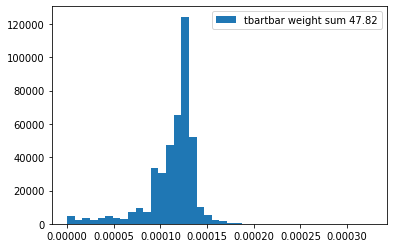

In [5]:
plt.hist(weights[0:425286], bins=40, label="tbartbar weight sum " +str(np.round(np.sum(weights[0:425286]),decimals=2)))
plt.legend()

In [6]:
np.sum(weights[0:425286])

47.82182804948535

In [7]:
ScaleWeights(targets,weights)
#scale the input between 0-1
scaler = StandardScaler().fit(input_features)
input_scaled = scaler.transform(input_features)


======Weight Statistic========================================
Weights::        W(1)=47.8218, W(0)=2983.69
Scaled weights:: W(1)=925640, W(0)=925640


input_tbartbar = input_scaled[0:425286,:]
weights_tbartbar = weights[0:425286]
input_tt = input_scaled[0:253953,:]
weights_tt = weights[0:253953]
both = np.concatenate([input_tt, input_tbartbar])

for i in range(input_scaled.shape[1]):
    max_val = both[:,i].max()
    min_val = both[:,i].min()
    bins = 40
    if i < 2:
        max_val = max_val*0.01
    if 1 < i <= 3:
        bins = 5
    if i == 4:
        max_val = max_val*0.1
    if i == 5:
        bins = 7
    plt.title(str(feature_names[i]))
    cqu = plt.hist(input_tt[:,i], bins=bins, range=(min_val, max_val), weights=weights_tt, histtype='step', label='tt', density=True)
    cuu = plt.hist(input_tbartbar[:,i], bins=bins, range=(min_val, max_val), weights=weights_tbartbar, histtype='step', label='tbartbar', density=True)
    plt.legend(frameon=False)
    save_name = path_tosave + "/Input_Feature_" + str(i) + ".png"
    plt.savefig(save_name)
    plt.show()

In [8]:
odd, even = Fold_Odd_Even(input_scaled, targets, weights, class_labels, Number)

In [9]:
#train, val, test = Train_Val_Test_Split(input_scaled, targets, weights, class_labels)
input_shape = odd[0].shape[1]
n_epochs = 30
batch_size = 20000

In [10]:
hist_odd, model_odd, hist_even, model_even = Train_Odd_Even(odd, even, n_epochs = n_epochs, batch_size = batch_size)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 6)]               0         
_________________________________________________________________
dense (Dense)                (None, 36)                252       
_________________________________________________________________
dense_1 (Dense)              (None, 48)                1776      
_________________________________________________________________
OutputLayer (Dense)          (None, 1)                 49        
Total params: 2,077
Trainable params: 2,077
Non-trainable params: 0
_________________________________________________________________
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 6)]               0         
__________________________________________

/home/avdgraaf/.local/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


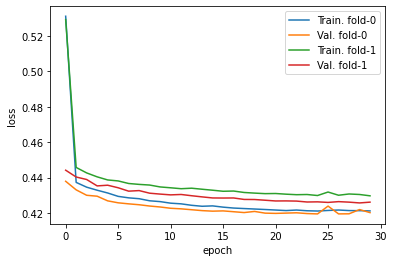

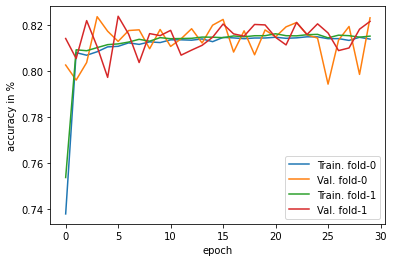

In [11]:
history_list = [hist_odd, hist_even]
Plot_Metrics_KFold(history_list, path_tosave)

Save_Model(model_odd, path_tosave, "_odd")
Save_Model(model_even, path_tosave, "_even")

pickle.dump(scaler, open(path_tosave + '/scaler.pkl','wb'))

In [12]:
#Function for Kfold Crossvalidation Training, it returns a list of the history and a list of the the models
#num_folds = 5
#history_list, model_list = Train_NN_Kfold(train, val, n_epochs, batch_size, num_folds)
#Plot_Metrics_KFold(history_list, path_tosave)

In [13]:
#model = Create_Model_basic(input_shape)
#fit_history = Train_NN(model, train+test, val, n_epochs, batch_size)
#Save_Model(model, path_tosave)
#Plot_Metrics(fit_history, path_tosave)
#pickle.dump(scaler, open(path_tosave + '/scaler.pkl','wb'))

# Evaluation

model_odd = Load_Model(path_tosave, name="_odd")
model_even = Load_Model(path_tosave, name="_even")

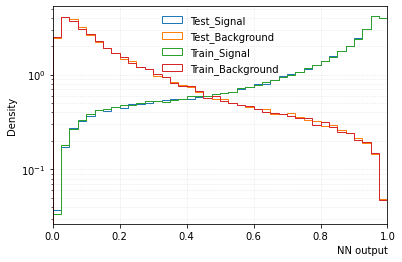

In [14]:
Plot_NN_Output(model_odd, odd, even, path_tosave, True)

/home/avdgraaf/.local/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


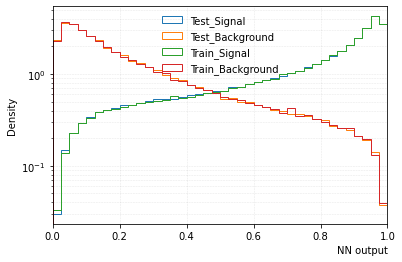

In [15]:
Plot_NN_Output(model_even, even, odd, path_tosave, True)

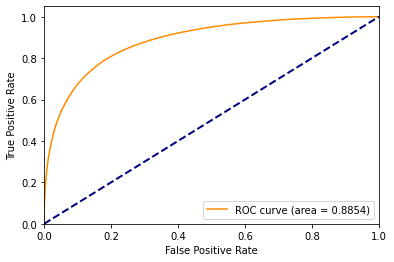

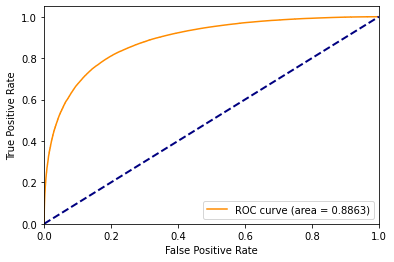

In [16]:
plot_roc_curve(model_even, odd, path_tosave)
plot_roc_curve(model_odd, even, path_tosave)

In [17]:
nn_scores_odd = model_even.predict(odd)
nn_scores_even = model_odd.predict(even)

fig = plt.figure(figsize=(16,8))
plt.grid(color='k', which='both', linestyle='--', lw=0.5, alpha=0.1, zorder = 0)
plt.xlabel("NN output", horizontalalignment='right', x=1)
plt.xlim([0,1])
plt.ylabel("Density")
plt.yscale('log')
histargs = {"bins":40, "range":(0,1.), "density":True, "histtype":'step'}
for i in range(No_Classes):
    plt.hist(nn_scores_test[test[3]==i],label = class_names[i], **histargs)
plt.legend(loc='upper center')
    #plt.hist(nn_scores_test[test[1]==0][test[3]==i],label = "Test_Background", **histargs)
plt.savefig(path_tosave+"/NN_Output_Classes.png")

# Input Correlation

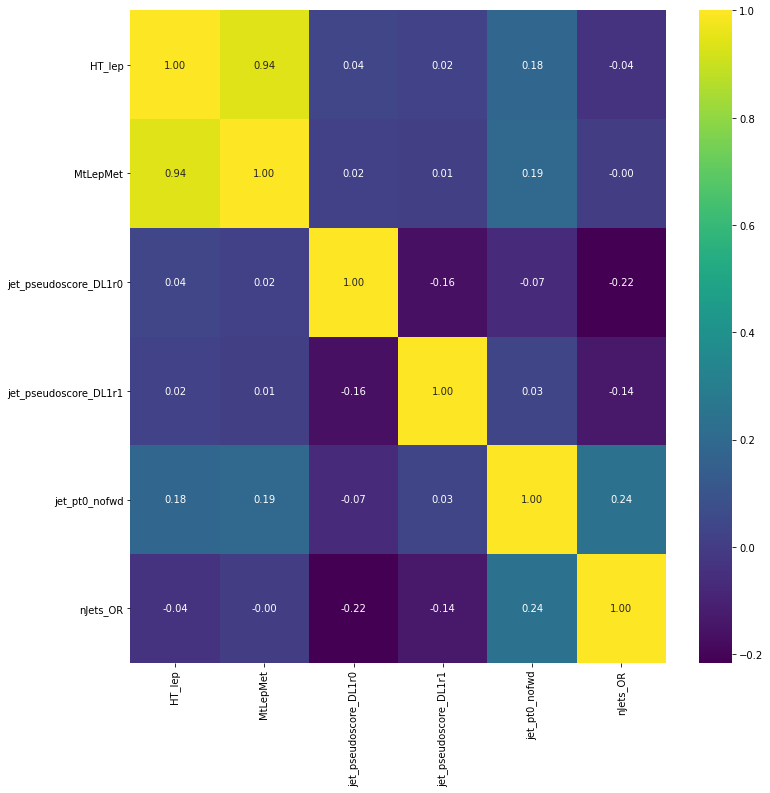

In [18]:
corr_mat = np.corrcoef(input_features, None, False)
plt.rcParams["figure.figsize"] = (12,12)
sns.heatmap(corr_mat, annot=True, cmap="viridis", xticklabels=feature_names, yticklabels=feature_names, fmt=".2f")
plt.savefig(path_tosave+"/Corr_Mat.png")

# Calc Signal cut for desired Singal Efficiency

In [19]:
Sig = nn_scores_odd[odd[1]==1]
Bkg = nn_scores_odd[odd[1]==0]
Sig_Eff, Bkg_Eff, Signal_Cut = Find_Eff_Cut(Sig=Sig, Bkg=Bkg, Signal_Eff=0.8)

Cut_Value: 0.467
Sig_Eff: 0.800
Bkg_Eff: 0.188
Bkg Rejection: 5.329


# Feature Importance

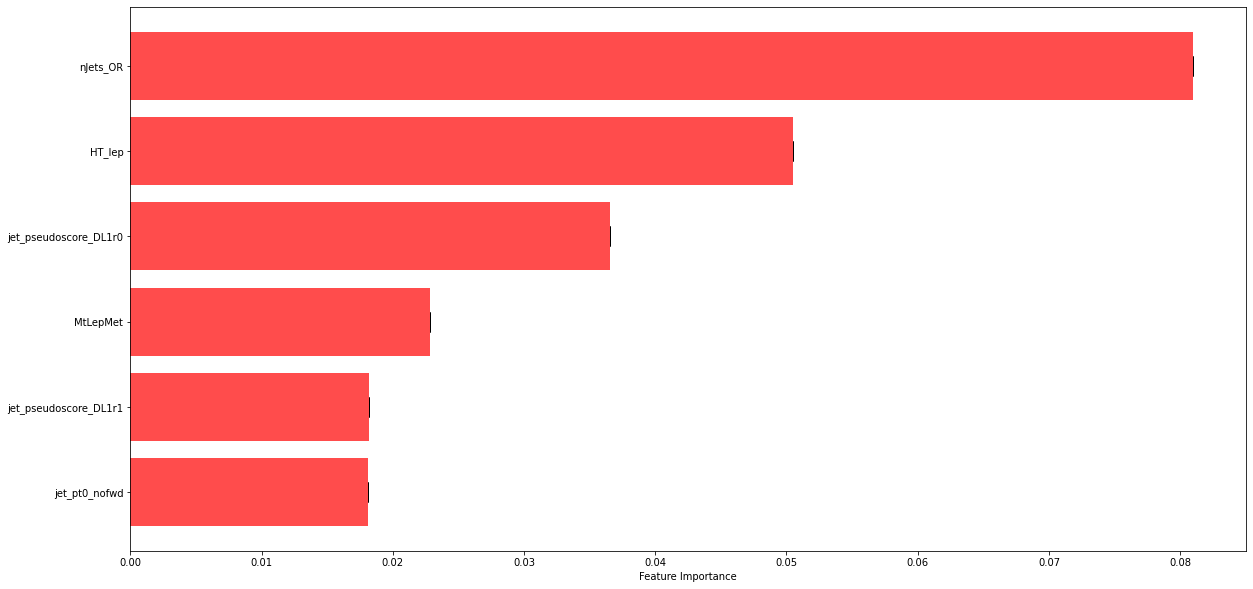

In [20]:
f, g = get_feature_importance(even, model_odd, Signal_Cut, 1)
idx = np.argsort(f)
fig, ax = plt.subplots(figsize=(20, 10))
ax.barh(range(even[0].shape[1]), np.sort(f), xerr=np.array(g)[idx], color="r", alpha=0.7, ecolor='black', capsize=10)
ax.set_yticks(range(even[0].shape[1]), np.array(feature_names)[idx])
ax.set_xlabel('Feature Importance')
plt.savefig(path_tosave + "/Feature_Importance_even.png")

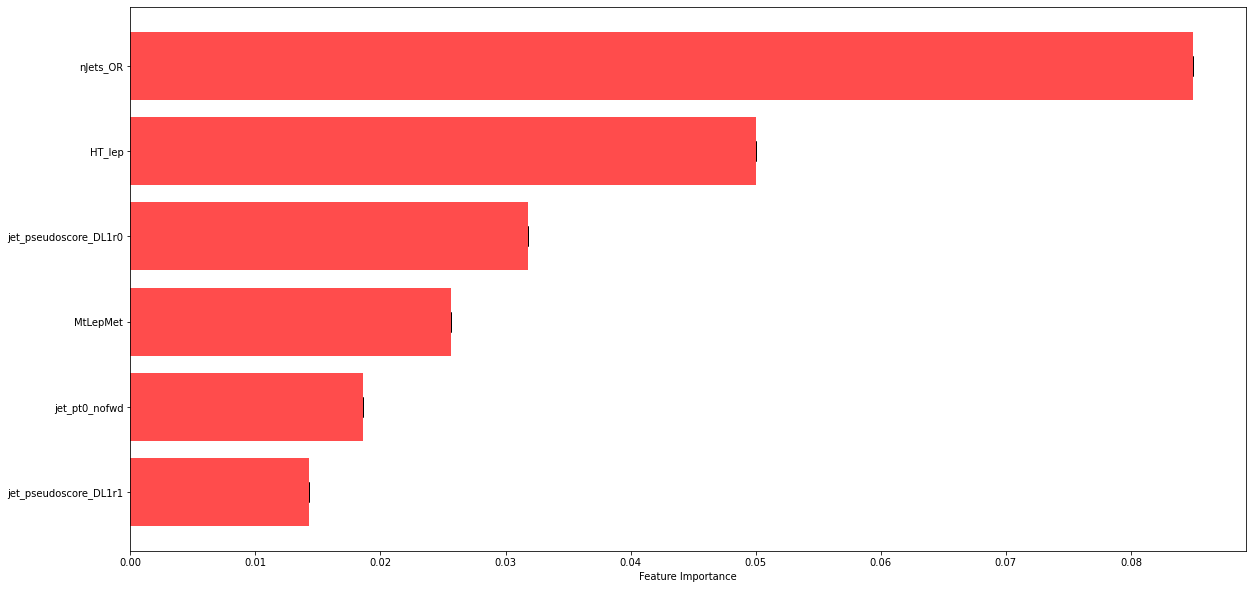

In [21]:
f, g = get_feature_importance(odd, model_even, Signal_Cut, 1)
idx = np.argsort(f)
fig, ax = plt.subplots(figsize=(20, 10))
ax.barh(range(even[0].shape[1]), np.sort(f), xerr=np.array(g)[idx], color="r", alpha=0.7, ecolor='black', capsize=10)
ax.set_yticks(range(even[0].shape[1]), np.array(feature_names)[idx])
ax.set_xlabel('Feature Importance')
plt.savefig(path_tosave + "/Feature_Importance_odd.png")

# Confusion Matrix

In [22]:
Sig = nn_scores_even[even[1]==1]
Bkg = nn_scores_even[even[1]==0]
Sig_Eff, Bkg_Eff, Signal_Cut_even = Find_Eff_Cut(Sig=Sig, Bkg=Bkg, Signal_Eff=0.8)

Cut_Value: 0.462
Sig_Eff: 0.800
Bkg_Eff: 0.185
Bkg Rejection: 5.412


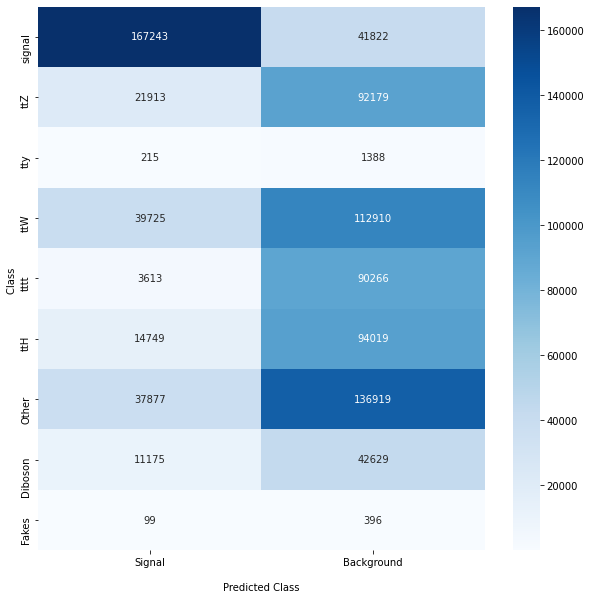

In [23]:
Make_Confusion_Matrix(even, nn_scores_even, Signal_Cut_even, class_names, path_tosave, False)

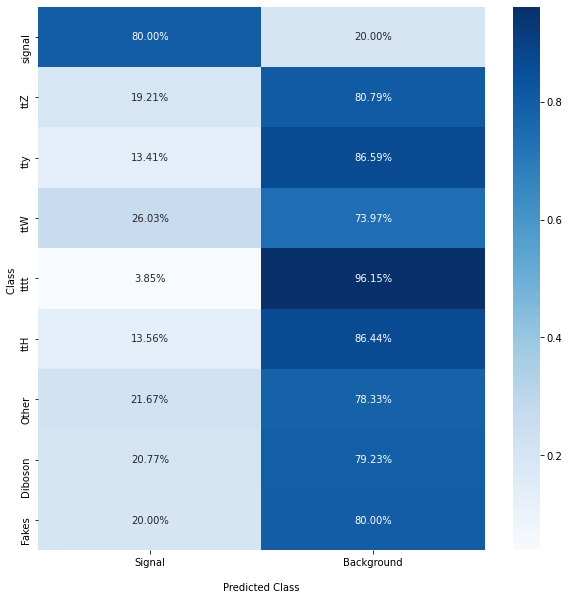

In [24]:
Make_Confusion_Matrix(even, nn_scores_even, Signal_Cut_even, class_names, path_tosave, True)

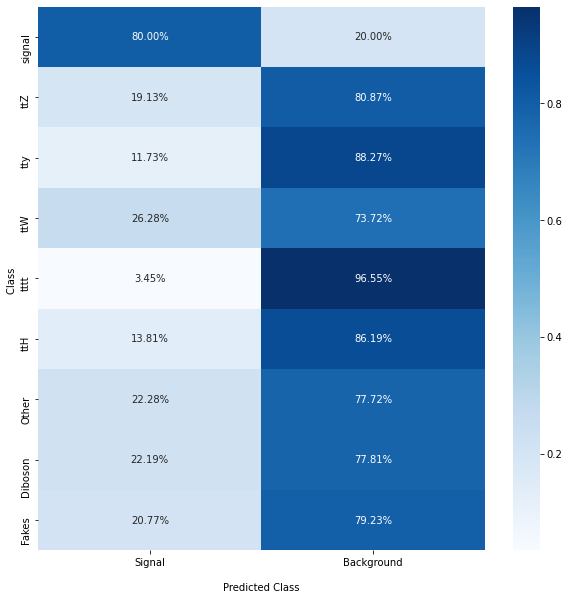

In [25]:
Make_Confusion_Matrix(odd, nn_scores_odd, Signal_Cut, class_names, path_tosave, True)

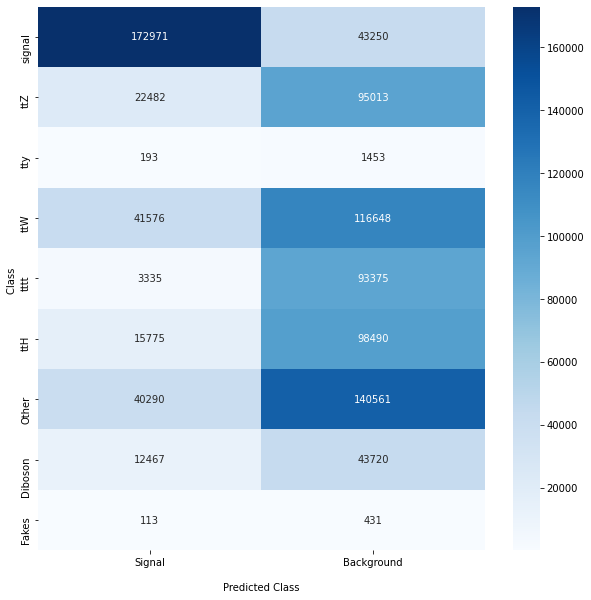

In [26]:
Make_Confusion_Matrix(odd, nn_scores_odd, Signal_Cut, class_names, path_tosave, False)